In [1]:
%matplotlib inline


# Gaussian Mixture Model Ellipsoids


Plot the confidence ellipsoids of a mixture of two Gaussians
obtained with Expectation Maximisation (``GaussianMixture`` class) and
Variational Inference (``BayesianGaussianMixture`` class models with
a Dirichlet process prior).

Both models have access to five components with which to fit the data. Note
that the Expectation Maximisation model will necessarily use all five
components while the Variational Inference model will effectively only use as
many as are needed for a good fit. Here we can see that the Expectation
Maximisation model splits some components arbitrarily, because it is trying to
fit too many components, while the Dirichlet Process model adapts it number of
state automatically.

This example doesn't show it, as we're in a low-dimensional space, but
another advantage of the Dirichlet process model is that it can fit
full covariance matrices effectively even when there are less examples
per cluster than there are dimensions in the data, due to
regularization properties of the inference algorithm.


In [257]:
from bokeh.plotting import figure,show
from bokeh.io import output_notebook,show,output_file,save
from bokeh.charts import Scatter


In [258]:
output_notebook()

Loading BokehJS ...

In [2]:
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture
from sklearn.decomposition import PCA

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


In [3]:
from matplotlib import gridspec
import seaborn as sns

In [4]:
def plot_results(X, Y_, means, covariances, index, title):
    plt.figure(figsize=(20,20))  #
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim([-2000,2000])
    plt.ylim([-1000,1000])
    #plt.xlim(-9., 5.)
    #plt.ylim(-3., 6.)
    #plt.xticks(())
    #plt.yticks(())
    plt.title(title)

In [9]:
########################### get some spikes ##############################

In [4]:
import os

In [7]:
os.getcwd()

'/Volumes/Mac HD/Dropbox (coxlab)/Scripts/Repositories/ScikitSort'

In [6]:
spiketimes_path = '/Users/guitchounts1/Documents/Ephys_Data/GRat21/636213969321601134/ChGroup_0/SpikeTimes'

spiketimes_file = open(spiketimes_path,"rb")

spiketimes = np.fromfile(spiketimes_file,dtype=np.uint64)

spiketimes_file.close

<function close>

In [7]:
spiketimes.shape

(15806043,)

In [8]:
spikes_path = '/Users/guitchounts1/Documents/Ephys_Data/GRat21/636213969321601134/ChGroup_0/Spikes'

spikes_file = open(spikes_path,"rb")

spikes = np.fromfile(spikes_file,dtype=np.int16)

spikes_file.close

<function close>

In [9]:
spikes.shape

(4046347008,)

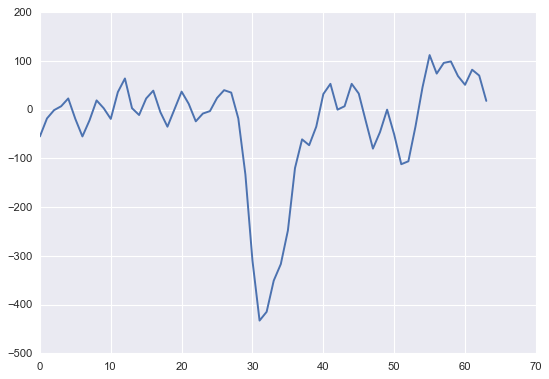

In [13]:
plt.plot(spikes[0:256:4]) #### looks like the values are arranged [ch0,ch1,ch2,ch3;ch0,ch1,ch2,ch3...]

In [10]:
spikes = np.reshape(spikes,[4,64,len(spikes)/(4*64)],'F')

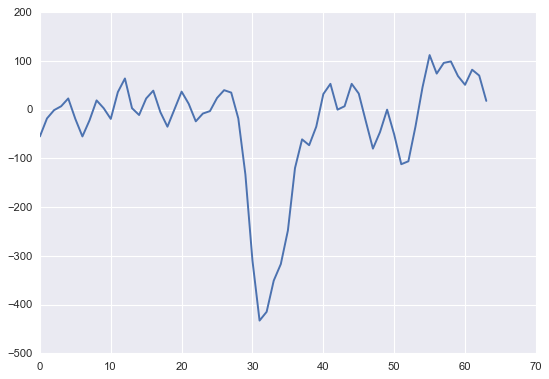

In [11]:
plt.plot(spikes[0,:,0])

In [16]:
spikes.shape

(4, 64, 15806043)

In [12]:
spike_vec = np.reshape(spikes,[4*64,spikes.shape[2]])

In [13]:
spike_vec.shape

(256, 15806043)

In [15]:
spikes = None

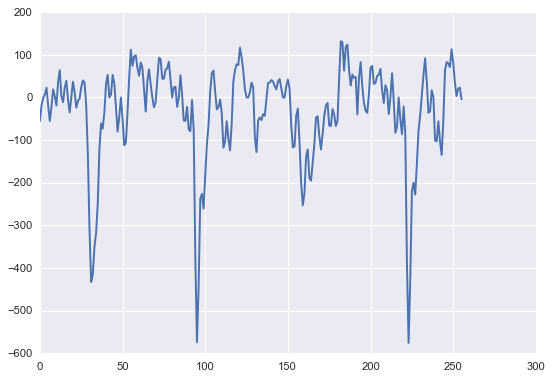

In [14]:
plt.plot(spike_vec[:,0])

In [20]:
peaks = spikes[:,31,:].T

In [36]:
peaks.shape

(15806043, 4)

In [37]:
peaks = peaks[ndx[0]:ndx[1]+1,:]

In [41]:
peaks.shape

(1960989, 4)

In [22]:
spikes = None

In [16]:
behaviortime_boundaries = [np.ceil(x*3e4) for x in [82719.6061261-1,97602.8439392+1]]

In [17]:
ndx = [np.where(spiketimes>=behaviortime_boundaries[0])[0].min(),np.where(spiketimes<=behaviortime_boundaries[1])[0].max()]

In [18]:
spiketimes = spiketimes[ndx[0]:ndx[1]+1] # +1 to include that last index

In [19]:
spike_vec = spike_vec[:,ndx[0]:ndx[1]+1]

In [20]:
spike_vec.shape

(256, 1960989)

In [21]:
reduced_data = PCA(n_components=4,whiten=True).fit_transform(spike_vec.T)

In [22]:
reduced_data.shape

(1960989, 4)

(-10, 10)

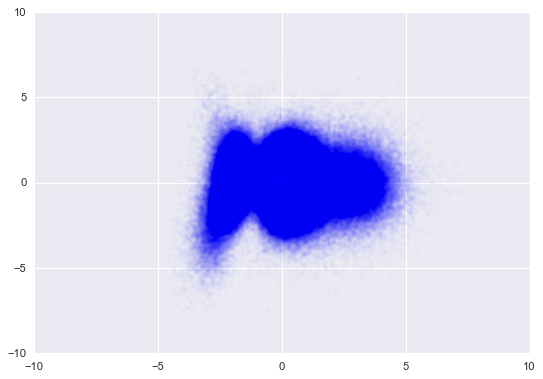

In [47]:
plt.scatter(reduced_data[:,0],reduced_data[:,1],alpha=0.01,lw = 0)
plt.xlim([-10,10])
plt.ylim([-10,10])

In [ ]:
plt.scatter(peaks[0:100000,0],peaks[0:100000,1],alpha=0.1,lw = 0)


In [18]:
all_features = np.vstack([peaks[0:10000,:].T,ch1pcs.T,ch2pcs.T,ch3pcs.T,ch4pcs.T])

In [19]:
all_features.shape

(12, 10000)

In [233]:
all_pcs = np.vstack([ch1pcs.T,ch2pcs.T,ch3pcs.T,ch4pcs.T])

In [234]:
all_pcs.shape

(8, 10000)

In [40]:
reduced_data.shape

(1960989, 4)

In [52]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type,max_iter=1000)
        gmm.fit(reduced_data)
        bic.append(gmm.bic(reduced_data))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)

clf = best_gmm
bars = []



In [54]:
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange','green','magenta','red'])

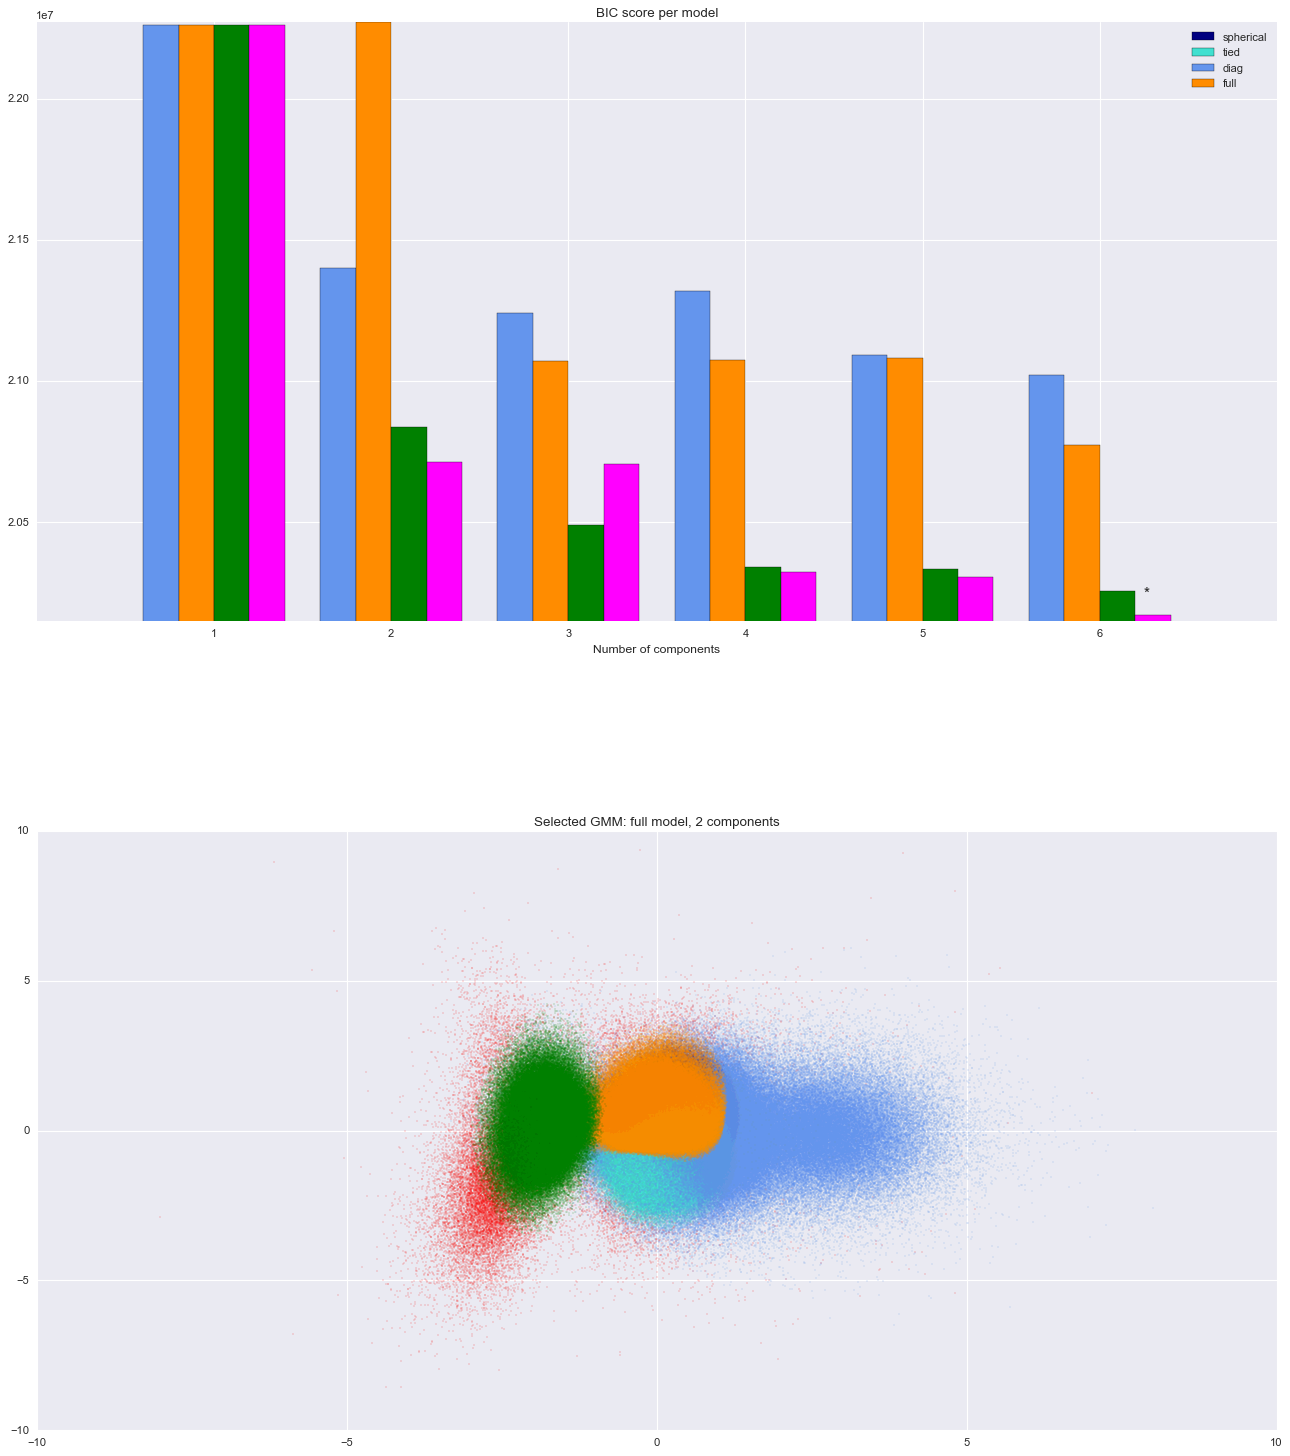

In [58]:
# Plot the BIC scores
plt.figure(figsize=(20,20))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)



# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(reduced_data)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        print 'not any'
        continue
    plt.scatter(reduced_data[Y_ == i, 0], reduced_data[Y_ == i, 1], .1, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    #splot.add_artist(ell)

#plt.xticks(())
#plt.yticks(())
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.title('Selected GMM: full model, 2 components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

In [77]:
gmm_dir = mixture.BayesianGaussianMixture(n_components=5, covariance_type='full',verbose=True,max_iter=500).fit(reduced_data)

Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
  Iteration 110
  Iteration 120
  Iteration 130
  Iteration 140
  Iteration 150
  Iteration 160
  Iteration 170
  Iteration 180
  Iteration 190
  Iteration 200
  Iteration 210
  Iteration 220
  Iteration 230
  Iteration 240
  Iteration 250
  Iteration 260
  Iteration 270
  Iteration 280
  Iteration 290
  Iteration 300
  Iteration 310
  Iteration 320
  Iteration 330
  Iteration 340
  Iteration 350
  Iteration 360
  Iteration 370
  Iteration 380
  Iteration 390
  Iteration 400
  Iteration 410
  Iteration 420
  Iteration 430
  Iteration 440
  Iteration 450
  Iteration 460
  Iteration 470
  Iteration 480
  Iteration 490
Initialization converged: False


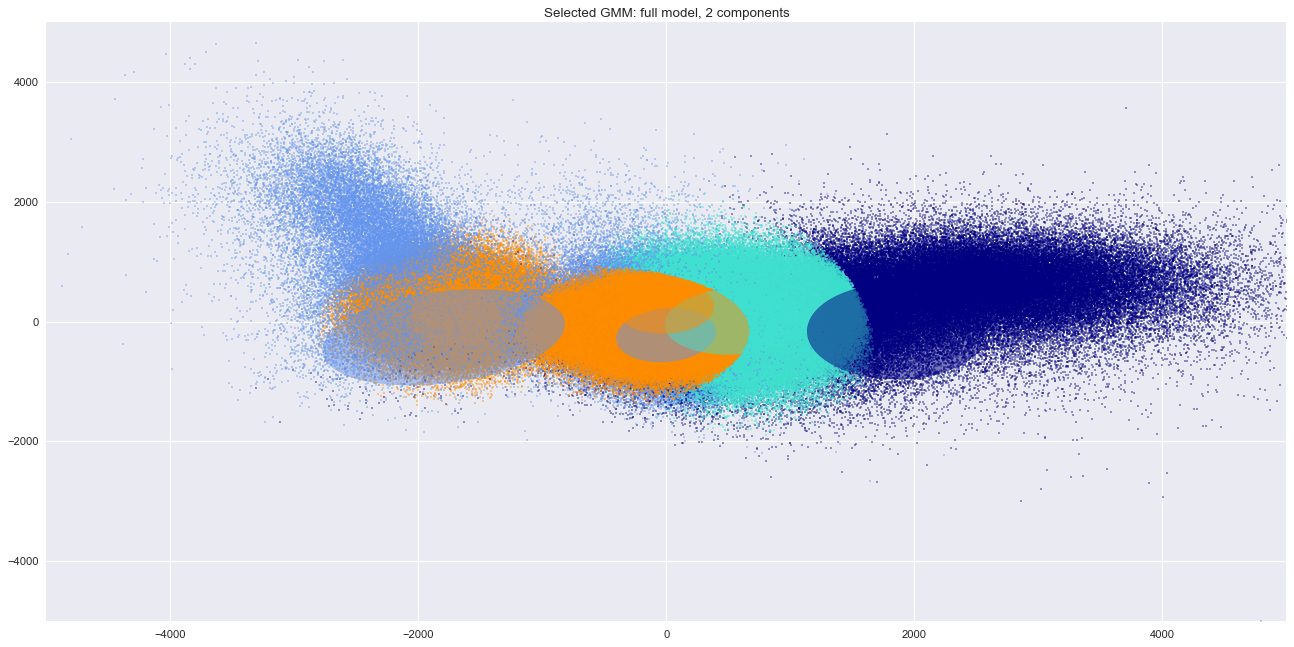

In [52]:
# Plot the winner
plt.figure(figsize=(20,20))
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(reduced_data)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(reduced_data[Y_ == i, 0], reduced_data[Y_ == i, 2], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

#plt.xticks(())
#plt.yticks(())
plt.xlim([-5000,5000])
plt.ylim([-5000,5000])
plt.title('Selected GMM: full model, 2 components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

In [68]:
reduced_features = PCA(n_components=2).fit_transform(all_features.T)

In [69]:
reduced_features.shape

(10000, 2)

(-2000, 2000)

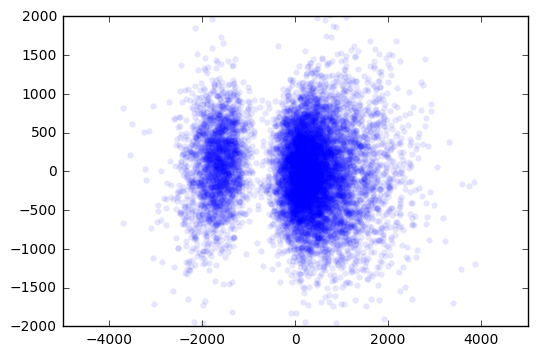

In [71]:
plt.scatter(reduced_features[:,0],reduced_features[:,1],alpha=0.1,lw = 0)
plt.xlim([-5000,5000])
plt.ylim([-2000,2000])


(-1000, 600)

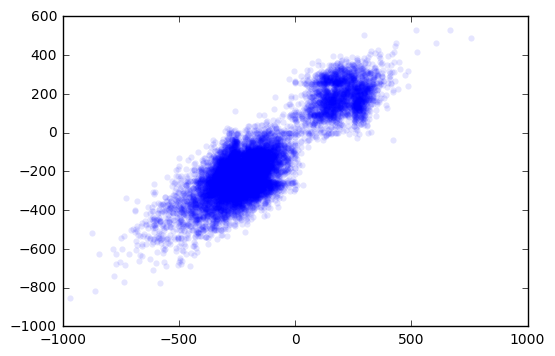

In [75]:
plt.scatter(all_features.T[:,0],all_features.T[:,1],alpha=0.1,lw = 0)
plt.xlim([-1000,1000])
plt.ylim([-1000,600])

(-1000, 600)

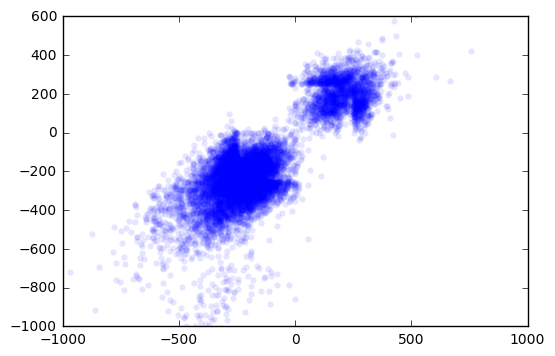

In [77]:
plt.scatter(all_features.T[:,0],all_features.T[:,3],alpha=0.1,lw = 0)
plt.xlim([-1000,1000])
plt.ylim([-1000,600])

(-2000, 2000)

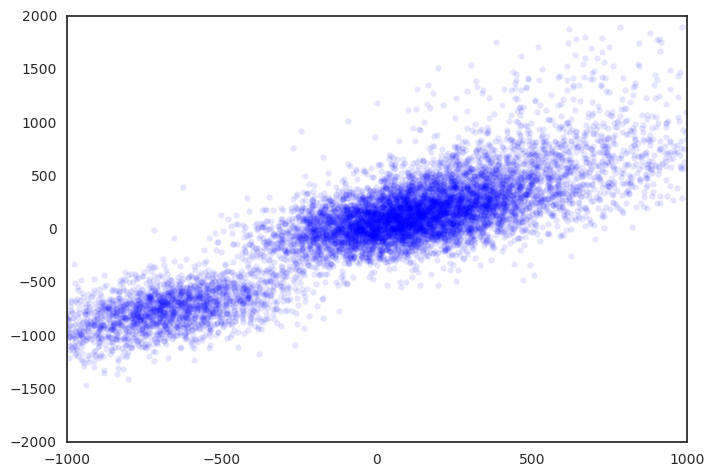

In [160]:
plt.scatter(all_features.T[:,4],all_features.T[:,10],alpha=0.1,lw = 0)
plt.xlim([-1000,1000])
plt.ylim([-2000,2000])

In [59]:
clust1spikes = np.squeeze(spike_vec[:,np.where(Y_==0)])

In [60]:
clust2spikes = np.squeeze(spike_vec[:,np.where(Y_==1)])

In [61]:
clust3spikes = np.squeeze(spike_vec[:,np.where(Y_==2)])

In [62]:
clust4spikes = np.squeeze(spike_vec[:,np.where(Y_==3)])

In [63]:
clust5spikes = np.squeeze(spike_vec[:,np.where(Y_==4)])

In [64]:
clust6spikes = np.squeeze(spike_vec[:,np.where(Y_==5)])

In [65]:
print 'num spikes in each cluster:', clust4spikes.shape

num spikes in each cluster: (256, 183788)


In [83]:
spikes.shape

(4, 64, 27813540)

In [161]:
clust1spikes.shape

(4, 64, 2949)

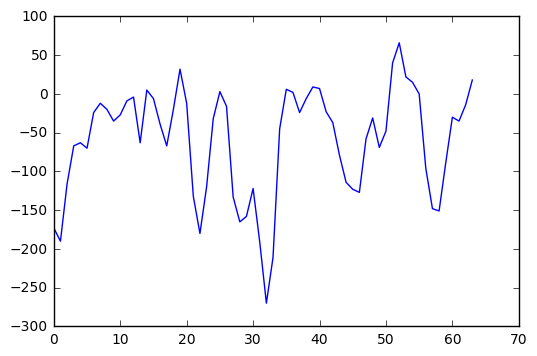

In [86]:
plt.plot(range(64),clust1spikes[0,:,1])

In [66]:
def plot_waveforms(spikes,clust_name):

    # spikes shape = e.g. (4, 64, 2949)

    fig = plt.figure(figsize=(20, 5)) 
    gs = gridspec.GridSpec(1, 1, width_ratios=[1, 1]) 
    ax1 = plt.subplot(gs[0])
    channels = spikes.shape[0]
    num_samples =spikes.shape[1]
    time_vec = range(channels*num_samples)

    allchans_avg = np.empty([channels*num_samples])
    allchans_std = np.empty([channels*num_samples])
    
    for i in range(channels):
         
        
        storewindows = spikes[i,:,:]  
        
        win_avg = np.mean(storewindows,axis=1)
        win_std = np.std(storewindows,axis=1)
        
        allchans_avg[i*(64):(i+1)*64] = win_avg
        allchans_std[i*(64):(i+1)*64] = win_std
        
    print len(allchans_avg)
    print type(allchans_avg)
    ax1 = errorfill(time_vec,allchans_avg,allchans_std)

    ax1 = sns.set_style("white")
    sns.despine()
    #plt.show()

    fig.tight_layout()

    fig.savefig("spikes.pdf")

In [67]:
def plot_tetrode(spikes,clust_name):

    # spikes shape = e.g. (256, 2949)

    fig = plt.figure(figsize=(20, 5)) 
    gs = gridspec.GridSpec(1, 1, width_ratios=[1, 1]) 
    ax1 = plt.subplot(gs[0])

    num_samples =spikes.shape[0]
    time_vec = range(num_samples)


    win_avg = np.mean(spikes,axis=1)
    win_std = np.std(spikes,axis=1)
    
    
    ax1 = errorfill(time_vec,win_avg,win_std)

    ax1 = sns.set_style("white")
    sns.despine()
    #plt.show()

    fig.tight_layout()

    fig.savefig('waveforms_cluster_' + clust_name + '.pdf')

In [69]:
def errorfill(x, y, yerr, color=None, alpha_fill=0.3, ax=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        #color = ax._get_lines.prop_cycler.next()
        #color= color['color']
        color = 'b'
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr

    ax.plot(x, y, color=color)
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill)

In [177]:
color = ax._get_lines.prop_cycler.next()

In [88]:
clust1spikes.shape

(256, 625800)

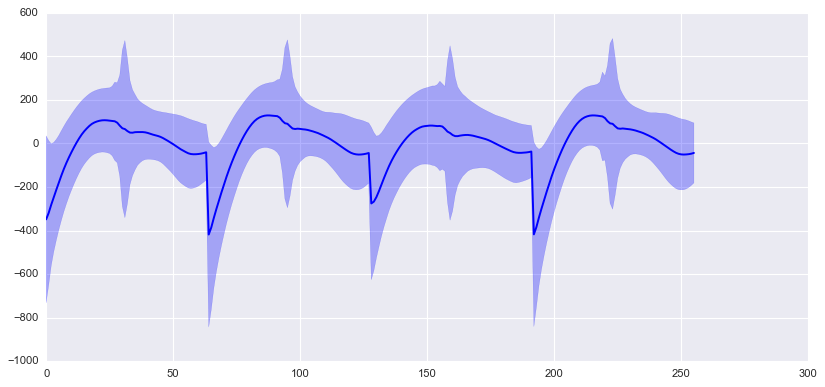

In [70]:
plot_tetrode(clust1spikes,'1')

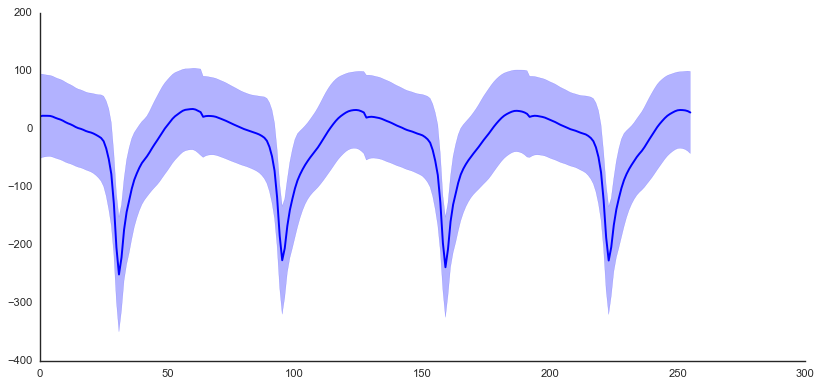

In [71]:
plot_tetrode(clust2spikes,'2')

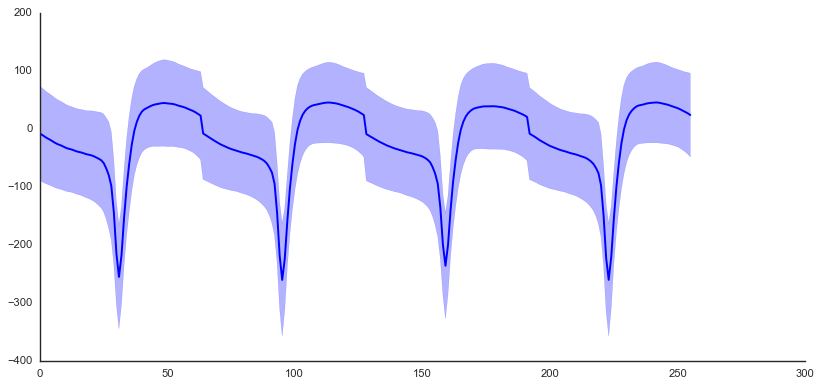

In [72]:
plot_tetrode(clust3spikes,'3')

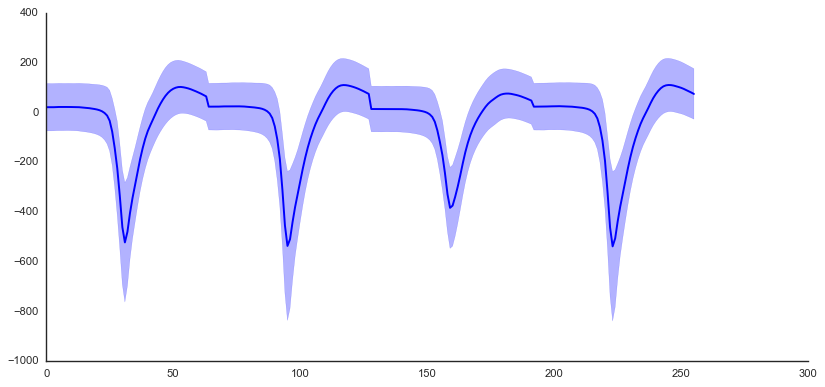

In [73]:
plot_tetrode(clust4spikes,'4')

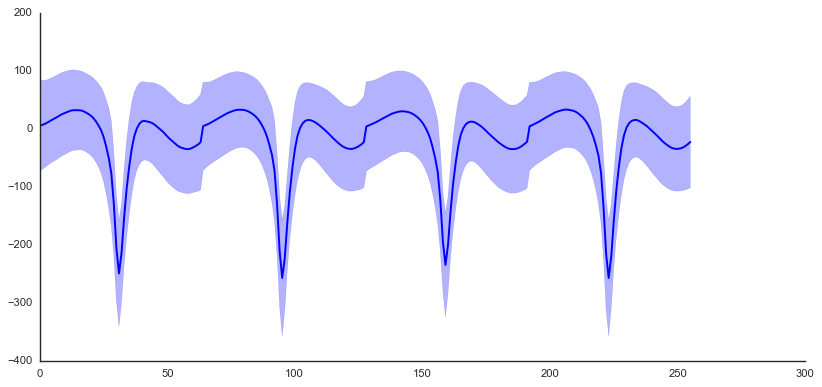

In [74]:
plot_tetrode(clust5spikes,'5')

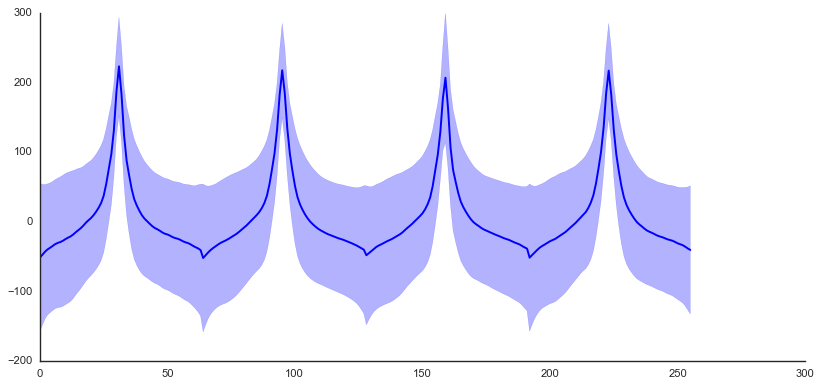

In [75]:
plot_tetrode(clust6spikes,'6')

In [102]:
Y_.shape

(1960989,)

In [103]:
spiketimes.shape

(1960989,)

In [5]:
import pandas as pd

In [171]:
d = dict(times = spiketimes/3e4,clusters=Y_)

In [172]:
cluster_assignments = pd.DataFrame.from_dict(d)

In [179]:
cluster_assignments.to_csv('cluster_assignments.csv')

In [133]:
# lower = 2481562006
# upper = 2481564751

temp_idx = (cluster_assignments.times[cluster_assignments.clusters==0] < 2481564751) & (cluster_assignments.times[cluster_assignments.clusters==0] > 2481562006)

In [176]:
cluster_assignments[100:150] #[cluster_assignments.clusters==0]

,clusters,times
100,1,82718.956100
101,5,82718.959067
102,5,82718.960133
103,0,82718.961700
104,5,82718.963967
105,1,82718.965633
106,0,82718.968433
107,5,82718.970667
108,5,82718.973433
109,3,82718.982033


In [394]:
if not 'spikes' in cluster_assignments.columns:
    print 'no spikes'
else:
    print 'yes spikes'

no spikes


In [235]:
cluster_assignments.times.irow(-1)

97603.842433333339

In [147]:
### we want the indices of temp_idx where temp_idx is TRUE
temp_idx

5          False
8          False
12         False
13         False
14         False
16         False
17         False
22         False
26         False
31         False
34         False
35          True
36          True
38          True
43          True
49          True
52          True
53          True
56          True
66         False
68         False
74         False
78         False
79         False
80         False
84         False
90         False
97         False
99         False
103        False
           ...  
1960889    False
1960890    False
1960891    False
1960893    False
1960895    False
1960898    False
1960900    False
1960903    False
1960906    False
1960907    False
1960923    False
1960924    False
1960925    False
1960926    False
1960928    False
1960932    False
1960939    False
1960940    False
1960950    False
1960952    False
1960953    False
1960963    False
1960966    False
1960973    False
1960974    False
1960975    False
1960976    False
1960978    Fal

In [159]:
y = temp_idx[temp_idx==True].index.values

In [160]:
y

array([35, 36, 38, 43, 49, 52, 53, 56])

In [163]:
x = cluster_assignments.times[y].values

In [164]:
x

array([2481562206, 2481562302, 2481562419, 2481562764, 2481563137,
       2481563344, 2481563414, 2481563612], dtype=uint64)

In [170]:
print 'blah blah %s blah %d' % ([str(len(x) for xx in x],2)

blah blah ['2481562206', '2481562302', '2481562419', '2481562764', '2481563137', '2481563344', '2481563414', '2481563612'] blah 2


In [135]:
cluster_assignments.shape

(1960989, 4)

In [125]:
cluster_assignments.clust5[0] = 10

/Users/guitchounts1/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [128]:
cluster_assignments.

ValueError: Length of values does not match length of index

In [54]:
import plotly.plotly as py
import plotly.graph_objs as go

In [203]:
viz_data = reduced_data[0:40000,:]

In [208]:
trace = []
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    if not np.any(Y_ == i):
        continue
    #plt.scatter(all_features.T[Y_ == i, 0], all_features.T[Y_ == i, 1], .8, color=color)

    
    
    
    temp_trace = go.Scatter3d(
        x=viz_data[Y_[0:40000] == i, 0], #x,
        y=viz_data[Y_[0:40000] == i, 1], #y,
        z=viz_data[Y_[0:40000] == i, 3], #z,
        mode='markers',
        marker=dict(
            size=1,
            line=dict(
                color= color,
                #width=0.5
            ),
            opacity=0.8
        )
    )
    trace.append(temp_trace)

data = trace
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

In [1]:
color

NameError: name 'color' is not defined

In [209]:
fig = go.Figure(data=data, layout=layout)

In [210]:
py.iplot(fig, filename='spike_clusters_2')

In [6]:
import plotly

In [7]:
plotly.__version__

'1.12.9'

In [8]:
import plotly.tools as tls
tls.set_credentials_file(username='guitchounts', api_key='s4P3RrzIeW9GlMWJTjOD')

In [216]:
all_features.shape

(12, 10000)

In [254]:
bin_time = 0.025 # 25 ms bins
num_bins = np.int(1.0 / bin_time)

In [255]:
num_bins

40

In [256]:
x = np.random.rand(num_bins,1)

In [356]:
firingrate_line = figure(width=1000, plot_height=500,y_axis_label='Firing Rate (Hz)',x_axis_label='Time (sec)')

In [261]:
hist,edges = np.histogram(x,bins=num_bins)

In [337]:
x_values = np.linspace(0,1,num_bins)

In [357]:
firingrate_line.line(x_values,x[:,0])

#firingrate_line.line(xx_edges,xx[:,0],color='red')

In [355]:
firingrate_line = None

In [358]:
show(firingrate_line)

In [322]:
import scipy

In [349]:
xxx = scipy.interpolate.interp1d(x_values,x[:,0],kind='cubic')

In [351]:
xxx

In [352]:
new_x_values = np.linspace(0,1,num_bins*10)
x_new = xxx(new_x_values)

In [359]:
firingrate_line.line(new_x_values,x_new,color='red')

In [360]:
show(firingrate_line)

In [361]:
hist,edges = np.histogram(x[:,0],bins=num_bins)

In [380]:
f = scipy.interpolate.interp1d(edges[:-1],hist,kind='cubic')

In [381]:
interp_x = np.linspace(edges[0],edges[-2],num_bins*10)

In [382]:
interp_y = f(interp_x)

In [376]:
interp_x

array([ 0.01290105,  0.01529935,  0.01769765,  0.02009594,  0.02249424,
        0.02489253,  0.02729083,  0.02968913,  0.03208742,  0.03448572,
        0.03688401,  0.03928231,  0.04168061,  0.0440789 ,  0.0464772 ,
        0.04887549,  0.05127379,  0.05367209,  0.05607038,  0.05846868,
        0.06086697,  0.06326527,  0.06566357,  0.06806186,  0.07046016,
        0.07285846,  0.07525675,  0.07765505,  0.08005334,  0.08245164,
        0.08484994,  0.08724823,  0.08964653,  0.09204482,  0.09444312,
        0.09684142,  0.09923971,  0.10163801,  0.1040363 ,  0.1064346 ,
        0.1088329 ,  0.11123119,  0.11362949,  0.11602778,  0.11842608,
        0.12082438,  0.12322267,  0.12562097,  0.12801927,  0.13041756,
        0.13281586,  0.13521415,  0.13761245,  0.14001075,  0.14240904,
        0.14480734,  0.14720563,  0.14960393,  0.15200223,  0.15440052,
        0.15679882,  0.15919711,  0.16159541,  0.16399371,  0.166392  ,
        0.1687903 ,  0.17118859,  0.17358689,  0.17598519,  0.17

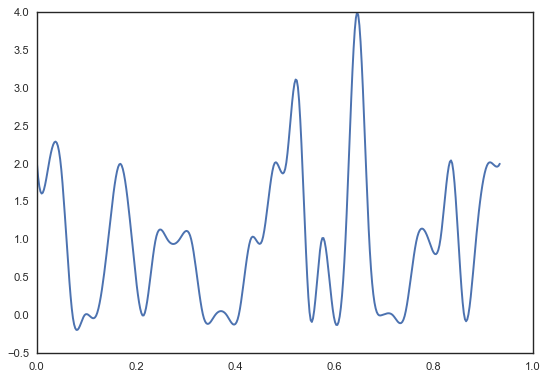

In [383]:
plt.plot(interp_x,interp_y)

(array([ 2.,  2.,  2.,  0.,  0.,  0.,  1.,  2.,  1.,  0.,  1.,  1.,  1.,
         1.,  0.,  0.,  0.,  0.,  1.,  1.,  2.,  2.,  3.,  0.,  1.,  0.,
         1.,  4.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  2.,  0.,  1.,  2.,  2.]),
 array([  4.01052957e-04,   2.43240564e-02,   4.82470599e-02,
          7.21700634e-02,   9.60930668e-02,   1.20016070e-01,
          1.43939074e-01,   1.67862077e-01,   1.91785081e-01,
          2.15708084e-01,   2.39631088e-01,   2.63554091e-01,
          2.87477095e-01,   3.11400098e-01,   3.35323101e-01,
          3.59246105e-01,   3.83169108e-01,   4.07092112e-01,
          4.31015115e-01,   4.54938119e-01,   4.78861122e-01,
          5.02784126e-01,   5.26707129e-01,   5.50630133e-01,
          5.74553136e-01,   5.98476140e-01,   6.22399143e-01,
          6.46322146e-01,   6.70245150e-01,   6.94168153e-01,
          7.18091157e-01,   7.42014160e-01,   7.65937164e-01,
          7.89860167e-01,   8.13783171e-01,   8.37706174e-01,
          8.61629178e-01,   8.

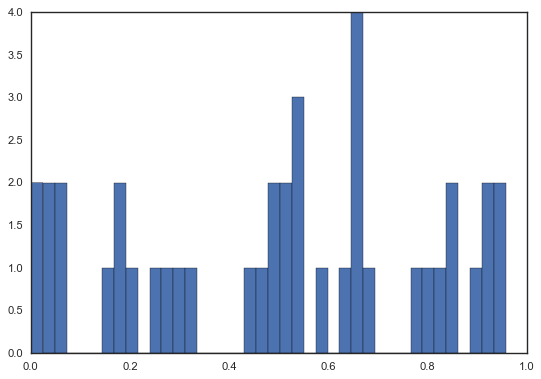

In [384]:
plt.hist(x,bins=num_bins)

In [396]:
import os

In [533]:
import pylab
from scipy import signal,stats

In [6]:
cluster_assignments = pd.read_csv('/Volumes/GG Data Raid/Ephys/grat21/636213969321601134/ChGroup_0/cluster_assignments.csv')

In [11]:
clu0_times = cluster_assignments.times.values[np.where(cluster_assignments.clusters==0)]

In [13]:
clu0_time_diffs = np.diff(clu0_times)

In [26]:
clu4_times = cluster_assignments.times.values[np.where(cluster_assignments.clusters==4)]
clu4_time_diffs = np.diff(clu4_times)

In [14]:
hist,edges = np.histogram(clu0_time_diffs,bins=100,range=[0,100])

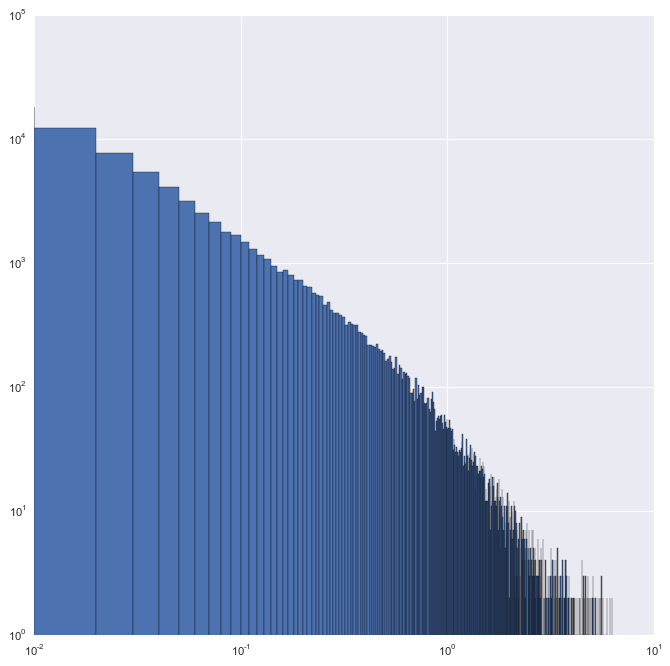

In [30]:
plt.figure(figsize=[10,10])
plt.hist(clu4_time_diffs,bins=1000,range=[0,10],log=True)
plt.xscale('log')

In [28]:
clu4_times

array([ 82718.7521333,  82718.8032333,  82718.8486   , ...,  97602.7896667,
        97602.9123667,  97603.5371   ])

In [29]:
clu4_time_diffs

array([ 0.0511   ,  0.0453667,  0.0462333, ...,  0.3461   ,  0.1227   ,
        0.6247333])